In [2]:
import pandas as pd
from libmadproject import *
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
import itertools
import matplotlib.pyplot as plt

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [3]:
def plotly_df(df, title = ''):
    data = []
#     print(df.index.name,df.columns[0])
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            #mode = 'lines',
            #name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    
#     fig.update_layout(
#     title="Plot Title",
#     xaxis_title="X Axis Title",
#     yaxis_title="X Axis Title",
#     legend_title="Legend Title",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="RebeccaPurple"
#     )
    
    iplot(fig, show_link=False)
  


### Importing data

In [4]:
c = ['data2001.csv','data2002.csv','data2003.csv','data2004.csv','data2005.csv','data2006.csv','data2007.csv','data2008.csv','data2009.csv','data2010.csv','data2011.csv','data2012.csv','data2013.csv','data2014.csv','data2015.csv','data2016.csv','data2017.csv','data2018.csv','data2019.csv','datos202008.csv']
c = ['data/'+ i for i in c]

In [5]:
df_total = daily_airmad_varios_mu_m3(c)

In [6]:
df_total.head()

level_0  index  PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD PUNTO_MUESTREO  \
0        0      0         28         79         4         1  28079004_1_38   
1        1      1         28         79         4         1  28079004_1_38   
2        2      2         28         79         4         1  28079004_1_38   
3        3      3         28         79         4         1  28079004_1_38   
4        4      4         28         79         4         1  28079004_1_38   

    ANO  MES  DIA  Value DIA_NUM MES_0      FECHA   FECHA_str  distrito  \
0  2001    1  D01   17.0      01    01 2001-01-01  2001-01-01         9   
1  2001    2  D01   40.0      01    02 2001-02-01  2001-02-01         9   
2  2001    3  D01   19.0      01    03 2001-03-01  2001-03-01         9   
3  2001    4  D01   14.0      01    04 2001-04-01  2001-04-01         9   
4  2001    5  D01   10.0      01    05 2001-05-01  2001-05-01         9   

    distrito_name         mag_name  
0  MoncloaAravaca  DioxidodeAzufre  
1  MoncloaAravaca  DioxidodeAzufre  
2  MoncloaAravaca  DioxidodeAzufre  
3  MoncloaAravaca  DioxidodeAzufre  
4  MoncloaAravaca  DioxidodeAzufre

### Mean values for pollution in Madrid

In [7]:
df_contamination = df_total.groupby('FECHA').mean()['Value'].reset_index()

In [8]:
# col_names = {'FECHA': 'date', 'Value':'y'}
# df_contamination = df_contaminacion.rename(col_names,axis = 1)
df_contamination.columns = ['ds', 'y']

In [9]:
df_contamination.tail()

ds          y
7177 2020-08-27  40.550137
7178 2020-08-28  28.051569
7179 2020-08-29  20.207237
7180 2020-08-30  19.631711
7181 2020-08-31  30.697000

In [10]:
plotly_df(df_contamination.set_index('ds')[['y']])

In [10]:
%%HTML
<div class='tableauPlaceholder' id='viz1602757336216' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;co&#47;contaminacion_madrid_6&#47;Hoja2&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='contaminacion_madrid_6&#47;Hoja2' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;co&#47;contaminacion_madrid_6&#47;Hoja2&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='es' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1602757336216');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

There are two regimenes: before 2008 and after 2008. The mean pollution values in Madrid have been decreasing over years, but in particular, we can take the start of the economic crisis in 2008 as a turning point.

*** DIBUJAR EVOLUCION MES A MES DESDE 2008 HASTA 2020

We want to predict what the contamination values would have been in Madrid if there hadn't been a quarantine.

### Predicting with FB Prophet

In [216]:
df_prediction 

ds           y
2555 2008-01-01  111.589250
2556 2008-01-02   87.244051
2557 2008-01-03   54.781266
2558 2008-01-04   72.684125
2559 2008-01-05   58.957778
...         ...         ...
6933 2019-12-27   74.812171
6934 2019-12-28  102.293487
6935 2019-12-29   94.344183
6936 2019-12-30   99.331569
6937 2019-12-31  112.293725

[4383 rows x 2 columns]

In [11]:
 
df_prediction = df_contamination[(df_contamination.ds >= '2008-01-01') & (df_contamination.ds <= '2019-12-31')]

In [12]:
# df_prediction = df_contamination.set_index('ds').resample('M').mean()


To make the prediction of 2019 we will use data from 2008

In [13]:
df_prediction = df_prediction[(df_prediction.ds >= '2008-01-01') & (df_prediction.ds <= '2019-12-31')]

In [14]:
df_prediction

ds           y
2555 2008-01-01  111.589250
2556 2008-01-02   87.244051
2557 2008-01-03   54.781266
2558 2008-01-04   72.684125
2559 2008-01-05   58.957778
...         ...         ...
6933 2019-12-27   74.812171
6934 2019-12-28  102.293487
6935 2019-12-29   94.344183
6936 2019-12-30   99.331569
6937 2019-12-31  112.293725

[4383 rows x 2 columns]

In [15]:
plotly_df(df_prediction.reset_index().set_index('ds')[['y']])

In [16]:
# predictions = 365
# train_df = df_prediction[:-predictions].copy()
# train_df = train_df.reset_index()

In [17]:
train_df = df_prediction

In [18]:
train_df

ds           y
2555 2008-01-01  111.589250
2556 2008-01-02   87.244051
2557 2008-01-03   54.781266
2558 2008-01-04   72.684125
2559 2008-01-05   58.957778
...         ...         ...
6933 2019-12-27   74.812171
6934 2019-12-28  102.293487
6935 2019-12-29   94.344183
6936 2019-12-30   99.331569
6937 2019-12-31  112.293725

[4383 rows x 2 columns]

In [170]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [173]:
future = m.make_future_dataframe(periods=366)


In [174]:
future

ds
0    2008-01-01
1    2008-01-02
2    2008-01-03
3    2008-01-04
4    2008-01-05
...         ...
4744 2020-12-27
4745 2020-12-28
4746 2020-12-29
4747 2020-12-30
4748 2020-12-31

[4749 rows x 1 columns]

In [175]:
forecast = m.predict(future)

In [176]:
forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2008-01-01  74.258699   80.724795  128.349067    74.258699    74.258699   
1    2008-01-02  74.241027   76.874366  128.112991    74.241027    74.241027   
2    2008-01-03  74.223354   78.983628  130.583856    74.223354    74.223354   
3    2008-01-04  74.205682   75.994905  128.008633    74.205682    74.205682   
4    2008-01-05  74.188010   69.271507  118.494540    74.188010    74.188010   
...         ...        ...         ...         ...          ...          ...   
4744 2020-12-27  40.586337   36.128223   85.232535    39.948167    41.309875   
4745 2020-12-28  40.575836   45.144965   94.273359    39.936808    41.303779   
4746 2020-12-29  40.565334   47.648166   95.307335    39.924415    41.297683   
4747 2020-12-30  40.554833   46.459560   96.146552    39.911775    41.291588   
4748 2020-12-31  40.544332   47.125427   96.665735    39.899136    41.285492   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0          30.157899             30.157899             30.157899  3.089555   
1          30.096305             30.096305             30.096305  3.424606   
2          30.229358             30.229358             30.229358  3.965223   
3          29.138746             29.138746             29.138746  3.291160   
4          19.922145             19.922145             19.922145 -5.501349   
...              ...                   ...                   ...       ...   
4744       19.721830             19.721830             19.721830 -8.847245   
4745       28.828362             28.828362             28.828362  0.578050   
4746       30.997355             30.997355             30.997355  3.089555   
4747       30.969719             30.969719             30.969719  3.424606   
4748       31.130752             31.130752             31.130752  3.965223   

      weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
0         3.089555      3.089555  27.068344     27.068344     27.068344   
1         3.424606      3.424606  26.671698     26.671698     26.671698   
2         3.965223      3.965223  26.264136     26.264136     26.264136   
3         3.291160      3.291160  25.847586     25.847586     25.847586   
4        -5.501349     -5.501349  25.423494     25.423494     25.423494   
...            ...           ...        ...           ...           ...   
4744     -8.847245     -8.847245  28.569075     28.569075     28.569075   
4745      0.578050      0.578050  28.250312     28.250312     28.250312   
4746      3.089555      3.089555  27.907801     27.907801     27.907801   
4747      3.424606      3.424606  27.545113     27.545113     27.545113   
4748      3.965223      3.965223  27.165529     27.165529     27.165529   

      multiplicative_terms  multiplicative_terms_lower  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      0.0                         0.0   
3                      0.0                         0.0   
4                      0.0                         0.0   
...                    ...                         ...   
4744                   0.0                         0.0   
4745                   0.0                         0.0   
4746                   0.0                         0.0   
4747                   0.0                         0.0   
4748                   0.0                         0.0   

      multiplicative_terms_upper        yhat  
0                            0.0  104.416598  
1                            0.0  104.337332  
2                            0.0  104.452713  
3                            0.0  103.344428  
4                            0.0   94.110154  
...                          ...         ...  
4744                         0.0   60.308167  
4745                         0.0   69.404198  
4746                         0.0   71.562690  
4747                         0.0   71.524552  


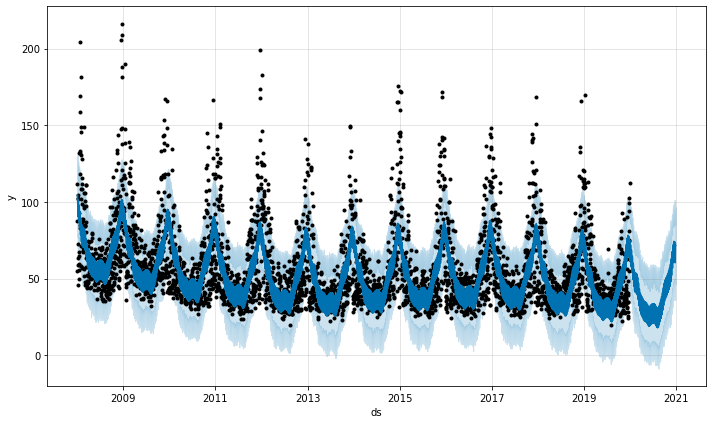

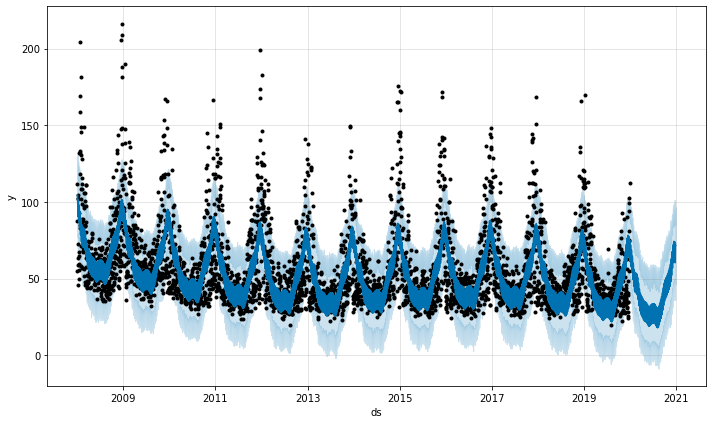

In [177]:
m.plot(forecast)

In [178]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_prediction.set_index('ds'))

In [185]:
cmp_df

yhat  yhat_lower  yhat_upper           y
ds                                                        
2008-01-01  104.416598   80.724795  128.349067  111.589250
2008-01-02  104.337332   76.874366  128.112991   87.244051
2008-01-03  104.452713   78.983628  130.583856   54.781266
2008-01-04  103.344428   75.994905  128.008633   72.684125
2008-01-05   94.110154   69.271507  118.494540   58.957778
...                ...         ...         ...         ...
2020-12-27   60.308167   36.128223   85.232535         NaN
2020-12-28   69.404198   45.144965   94.273359         NaN
2020-12-29   71.562690   47.648166   95.307335         NaN
2020-12-30   71.524552   46.459560   96.146552         NaN
2020-12-31   71.675084   47.125427   96.665735         NaN

[4749 rows x 4 columns]

In [179]:
df_cv = cross_validation(m,initial = '730 days',period = '180 days', horizon = '365 days')

INFO:fbprophet:Making 19 forecasts with cutoffs between 2010-02-16 00:00:00 and 2018-12-31 00:00:00


In [180]:
df_cv.tail()

ds       yhat  yhat_lower  yhat_upper           y     cutoff
6930 2019-12-27  80.156772   55.122053  104.726050   74.812171 2018-12-31
6931 2019-12-28  70.241701   44.695669   96.372925  102.293487 2018-12-31
6932 2019-12-29  66.199872   39.815446   91.024613   94.344183 2018-12-31
6933 2019-12-30  75.080984   50.550484   99.561641   99.331569 2018-12-31
6934 2019-12-31  77.015529   51.179639  102.564946  112.293725 2018-12-31

In [181]:
df_p = performance_metrics(df_cv)

In [182]:
df_p

horizon         mse       rmse        mae      mape     mdape  coverage
0    37 days  282.683271  16.813187  12.698842  0.271691  0.212523  0.881066
1    38 days  277.802993  16.667423  12.540407  0.267325  0.206411  0.883952
2    39 days  274.085138  16.555517  12.451732  0.265323  0.205390  0.887522
3    40 days  272.328930  16.502392  12.452003  0.266940  0.212523  0.890408
4    41 days  266.944126  16.338425  12.352443  0.267065  0.212523  0.892610
..       ...         ...        ...        ...       ...       ...       ...
324 361 days  868.417785  29.468929  20.410235  0.368986  0.237993  0.700843
325 362 days  862.560084  29.369373  20.420017  0.371459  0.239928  0.698565
326 363 days  845.031682  29.069429  20.213433  0.369952  0.241451  0.702210
327 364 days  826.166154  28.743106  19.978066  0.365745  0.239928  0.705020
328 365 days  822.249415  28.674892  19.963740  0.363960  0.239928  0.704337

[329 rows x 7 columns]

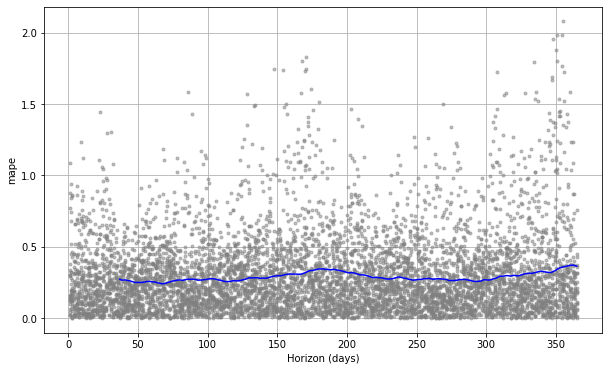

In [183]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [203]:
compare = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_contamination.set_index('ds'))

In [204]:
compare

yhat  yhat_lower  yhat_upper           y
ds                                                        
2008-01-01  104.416598   80.724795  128.349067  111.589250
2008-01-02  104.337332   76.874366  128.112991   87.244051
2008-01-03  104.452713   78.983628  130.583856   54.781266
2008-01-04  103.344428   75.994905  128.008633   72.684125
2008-01-05   94.110154   69.271507  118.494540   58.957778
...                ...         ...         ...         ...
2020-12-27   60.308167   36.128223   85.232535         NaN
2020-12-28   69.404198   45.144965   94.273359         NaN
2020-12-29   71.562690   47.648166   95.307335         NaN
2020-12-30   71.524552   46.459560   96.146552         NaN
2020-12-31   71.675084   47.125427   96.665735         NaN

[4749 rows x 4 columns]

In [206]:
compare = compare.dropna()
compare

yhat  yhat_lower  yhat_upper           y
ds                                                        
2008-01-01  104.416598   80.724795  128.349067  111.589250
2008-01-02  104.337332   76.874366  128.112991   87.244051
2008-01-03  104.452713   78.983628  130.583856   54.781266
2008-01-04  103.344428   75.994905  128.008633   72.684125
2008-01-05   94.110154   69.271507  118.494540   58.957778
...                ...         ...         ...         ...
2020-08-27   33.940203    9.096080   57.845413   40.550137
2020-08-28   33.554046    7.378566   58.117550   28.051569
2020-08-29   25.050888    1.296430   51.454447   20.207237
2020-08-30   21.995345   -3.822748   46.481498   19.631711
2020-08-31   31.711854    7.635031   57.806914   30.697000

[4627 rows x 4 columns]

In [208]:
compare = compare.reset_index()
compare = compare[(compare.ds > '2019-12-31')]
compare

ds       yhat  yhat_lower  yhat_upper           y
4383 2020-01-01  74.870241   48.271749  100.200281   98.700526
4384 2020-01-02  75.003710   51.519633   99.875867  105.133041
4385 2020-01-03  73.911583   47.500438   98.471072  112.060461
4386 2020-01-04  64.692023   40.206283   92.516789   49.464771
4387 2020-01-05  60.911534   35.063711   85.919201   74.387386
...         ...        ...         ...         ...         ...
4622 2020-08-27  33.940203    9.096080   57.845413   40.550137
4623 2020-08-28  33.554046    7.378566   58.117550   28.051569
4624 2020-08-29  25.050888    1.296430   51.454447   20.207237
4625 2020-08-30  21.995345   -3.822748   46.481498   19.631711
4626 2020-08-31  31.711854    7.635031   57.806914   30.697000

[244 rows x 5 columns]

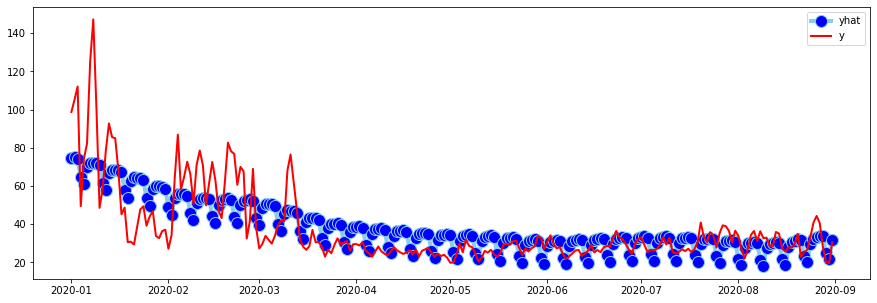

In [212]:
plt.figure(figsize = (15,5))
plt.plot( 'ds', 'yhat', data=compare, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'ds', 'y', data=compare, marker='', color='red', linewidth=2)
plt.legend()



### Traing up to 15th March and predicting up to nowadays (2008-Mar2020)

In [1]:
# df_prediction = df_contamination[(df_contamination.ds >= '2008-01-01') & (df_contamination.ds <= '2020-03-14')]
# train_df = df_prediction
# m = Prophet()
# m.fit(train_df)
# future = m.make_future_dataframe(periods=100)
# forecast = m.predict(future)
# m.plot(forecast)
# cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_prediction.set_index('ds'))
# df_cv = cross_validation(m,initial = '730 days',period = '50 days', horizon = '100 days')
# df_p = performance_metrics(df_cv)
# fig = plot_cross_validation_metric(df_cv, metric='mape')
# compare = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_contamination.set_index('ds'))
# compare = compare.dropna()
# compare = compare.reset_index()
# compare = compare[(compare.ds > '2020-03-14')]
# plt.figure(figsize = (15,5))
# plt.plot( 'ds', 'yhat', data=compare, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
# plt.plot( 'ds', 'y', data=compare, marker='', color='red', linewidth=2)
# plt.legend()

In [19]:
df_prediction = df_contamination[(df_contamination.ds >= '2008-01-01') & (df_contamination.ds <= '2020-03-14')]
train_df = df_prediction


In [22]:
m = Prophet()
m.fit(train_df)
future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


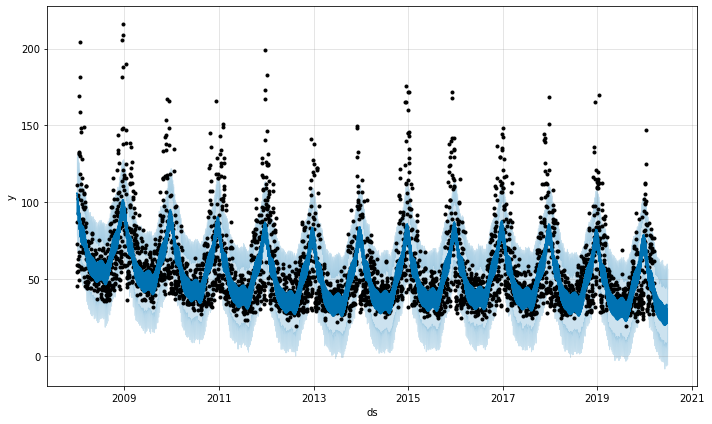

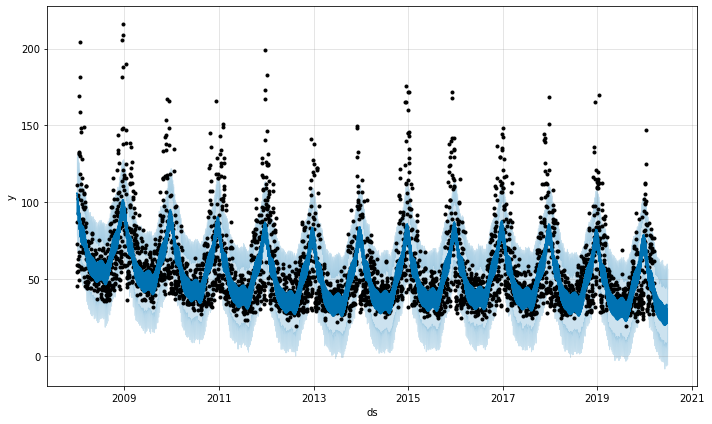

In [23]:
m.plot(forecast)


In [26]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_prediction.set_index('ds'))
df_cv = cross_validation(m,initial = '730 days',period = '50 days', horizon = '100 days')
df_p = performance_metrics(df_cv)


INFO:fbprophet:Making 73 forecasts with cutoffs between 2010-01-26 00:00:00 and 2019-12-05 00:00:00


In [30]:
df_p

horizon         mse       rmse        mae      mape     mdape  coverage
0   10 days  447.109268  21.144958  14.301354  0.267408  0.199362  0.841096
1   11 days  420.509240  20.506322  14.018901  0.265945  0.200061  0.846575
2   12 days  403.285843  20.081978  13.908726  0.265975  0.199810  0.843836
3   13 days  393.149358  19.827994  13.893213  0.265248  0.211262  0.846575
4   14 days  386.233551  19.652826  13.919249  0.266159  0.217419  0.850685
..      ...         ...        ...        ...       ...       ...       ...
86  96 days  406.395536  20.159254  14.436474  0.305079  0.226655  0.853425
87  97 days  372.811660  19.308331  14.044572  0.302526  0.229151  0.857534
88  98 days  350.458177  18.720528  13.845427  0.302034  0.232506  0.857534
89  99 days  347.827811  18.650142  13.638869  0.292725  0.222900  0.857534
90 100 days  347.622966  18.644650  13.528048  0.286835  0.217227  0.856164

[91 rows x 7 columns]

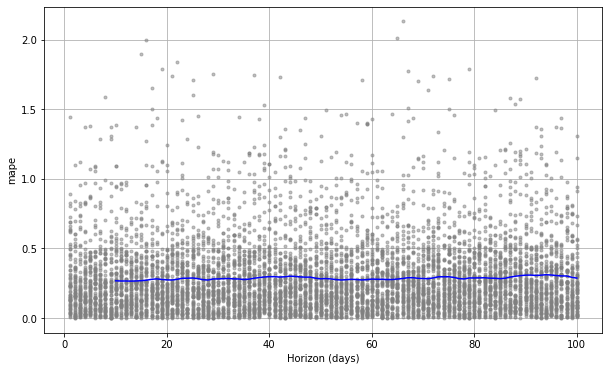

In [27]:
fig = plot_cross_validation_metric(df_cv, metric='mape')


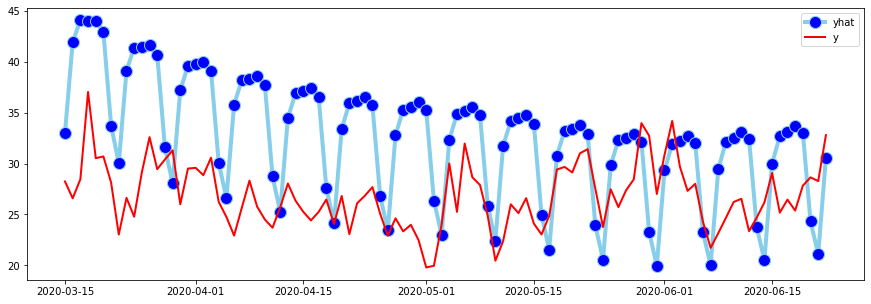

In [29]:
compare = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_contamination.set_index('ds'))
compare = compare.dropna()
compare = compare.reset_index()
compare = compare[(compare.ds > '2020-03-14')]
plt.figure(figsize = (15,5))
plt.plot( 'ds', 'yhat', data=compare, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'ds', 'y', data=compare, marker='', color='red', linewidth=2)
plt.legend()

In [41]:
((compare['yhat']-compare['y'])/compare['y']).mean()*100

21.87465626078363

### Hyperparameter tunning: Traing up to 15th March and predicting the next 100 days 

In [42]:
df_prediction = df_contamination[(df_contamination.ds >= '2008-01-01') & (df_contamination.ds <= '2020-03-14')]
train_df = df_prediction


In [43]:
# Python
cutoffs = pd.to_datetime(['2019-02-15', '2019-08-15', '2019-02-15'])
df_cv2 = cross_validation(m, horizon='100 days')


INFO:fbprophet:Making 80 forecasts with cutoffs between 2009-02-10 00:00:00 and 2019-12-05 00:00:00


In [45]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here





In [46]:
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 271 forecasts with cutoffs between 2009-01-11 00:00:00 and 2020-02-13 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 271 forecasts with cutoffs between 2009-01-11 00:00:00 and 2020-02-13 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 271 forecasts with cutoffs between 2009-01-11 00:00:00 and 2020-02-13 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 271 forecasts with cutoffs between 2009-01-11 00:00:00 and 2020-02-13 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 271 forecasts with cutoffs between 2009-01-11 00:00:00 and 2020-

In [47]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01  21.775329
1                     0.001                     0.10  22.537702
2                     0.001                     1.00  22.574225
3                     0.001                    10.00  22.561302
4                     0.010                     0.01  20.323860
5                     0.010                     0.10  20.758195
6                     0.010                     1.00  20.797145
7                     0.010                    10.00  20.800450
8                     0.100                     0.01  20.674062
9                     0.100                     0.10  20.701740
10                    0.100                     1.00  20.715371
11                    0.100                    10.00  20.719292
12                    0.500                     0.01  21.248648
13                    0.500                     0.10  21.479498
14                    0.500             

min rmse changepoint_prior_scale =  0.010, seasonality_prior_scale = 0.01  rmse = 20.323860

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01  21.775329
1                     0.001                     0.10  22.537702
2                     0.001                     1.00  22.574225
3                     0.001                    10.00  22.561302
4                     0.010                     0.01  20.323860
5                     0.010                     0.10  20.758195
6                     0.010                     1.00  20.797145
7                     0.010                    10.00  20.800450
8                     0.100                     0.01  20.674062
9                     0.100                     0.10  20.701740
10                    0.100                     1.00  20.715371
11                    0.100                    10.00  20.719292
12                    0.500                     0.01  21.248648
13                    0.500                     0.10  21.479498
14                    0.500                     1.00  22.188889
15                    0.500                    10.00  22.196885

We take the combination of parameters that resulting in lower rmse are the optimal ones.

### Prediction with optimized parameters

In [10]:
df_prediction = df_contamination[(df_contamination.ds >= '2008-01-01') & (df_contamination.ds <= '2020-03-14')]
train_df = df_prediction
m = Prophet(changepoint_prior_scale =  0.010, seasonality_prior_scale = 0.01)
m.fit(train_df)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


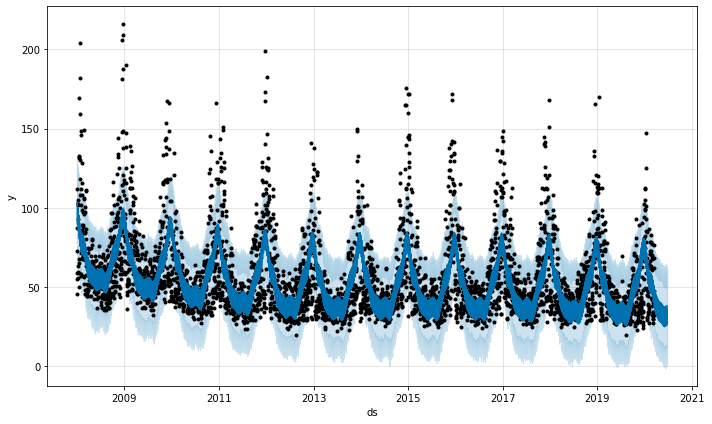

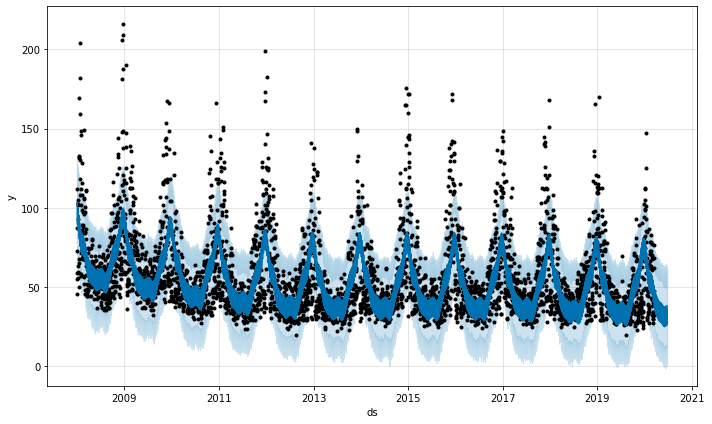

In [11]:
future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)
m.plot(forecast)



In [13]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_prediction.set_index('ds'))
df_cv = cross_validation(m,initial = '730 days',period = '50 days', horizon = '100 days')
df_p = performance_metrics(df_cv)

INFO:fbprophet:Making 73 forecasts with cutoffs between 2010-01-26 00:00:00 and 2019-12-05 00:00:00


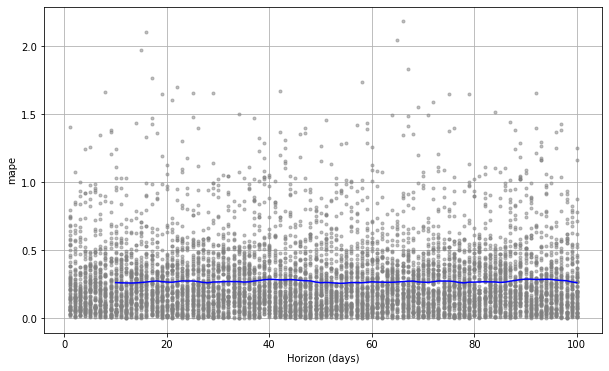

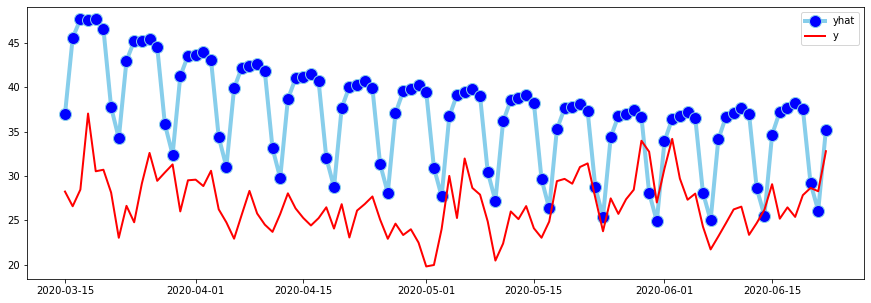

In [14]:
fig = plot_cross_validation_metric(df_cv, metric='mape')
compare = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_contamination.set_index('ds'))
compare = compare.dropna()
compare = compare.reset_index()
compare = compare[(compare.ds > '2020-03-14')]
plt.figure(figsize = (15,5))
plt.plot( 'ds', 'yhat', data=compare, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'ds', 'y', data=compare, marker='', color='red', linewidth=2)
plt.legend()

### How much has the contamination dropped due to the quarantine compared to what was expected?

In [15]:
((compare['yhat']-compare['y'])/compare['y']).mean()*100

38.30496381364385

In [ ]:
# 38%